In [1]:
# %pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import math
import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re
import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [40]:
from scipy.signal import butter, lfilter
def getseiztimes(onsettimes, offsettimes):
    minsize = np.min((len(onsettimes),len(offsettimes)))
    seizonsets = []
    seizoffsets = []
    
    # perform some checks
    if minsize == 0:
        print "no full onset/offset available!"
        return 0
    
    idx = 0
    # to store the ones we are checking rn
    _onset = onsettimes[idx]
    _offset = offsettimes[idx]
    seizonsets.append(_onset)
    
    # start loop after the first onset/offset pair
    for i in range(1,minsize):        
        # to store the previoius values
        _nextonset = onsettimes[i]
        _nextoffset = offsettimes[i]
        
        # check this range and add the offset if it was a full seizure
        # before the next seizure
        if _nextonset < _offset:
            _offset = _nextoffset
            
            if i == minsize-1 and len(seizoffsets) == 0:
                seizoffsets.append(_offset)
        else:
            seizoffsets.append(_offset)
            idx = i
            # to store the ones we are checking rn
            _onset = onsettimes[idx]
            _offset = offsettimes[idx]
            seizonsets.append(_onset)
    if len(seizonsets) != len(seizoffsets):
        seizonsets = seizonsets[0:len(seizoffsets)]
    return seizonsets, seizoffsets
            
def getonsetsoffsets(zts, ezindices, pzindices, delta=0.2/8):
    # create lambda function for checking the indices
    check = lambda indices: isinstance(indices,np.ndarray) and len(indices)>=1

    onsettimes=np.array([])
    offsettimes=np.array([])
    if check(ezindices):
        for ezindex in ezindices:
            _onsettimes, _offsettimes = postprocessor.findonsetoffset(zts[ezindex, :].squeeze(), 
                                                                    delta=delta)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    if check(pzindices):
        for pzindex in pzindices:
            _onsettimes, _offsettimes = postprocessor.findonsetoffset(zts[pzindex, :].squeeze(), 
                                                                    delta=delta)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    # first sort onsettimes and offsettimes
    onsettimes.sort()
    offsettimes.sort()
    
    return onsettimes, offsettimes

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

In [60]:
patients = ['id001_ac', 'id002_cj', 'id014_rb']
patient = 'id014_rb'

MOVECONTACT = 1

print patient
#     patient='cj'
# 1000 = 1 second
samplerate = 1000 # Hz
sim_length = 240*samplerate
period = 1

######### Epileptor Parameters ##########
# intialized hard coded parameters
epileptor_r = 0.0002/1.5    # Temporal scaling in the third state variable
epiks = -0.01                 # Permittivity coupling, fast to slow time scale
epitt = 0.01               # time scale of simulation
epitau = 10                # Temporal scaling coefficient in fifth st var
# x0c value = -2.05
x0norm=-2.4
x0ez=-1.7
x0pz=-2.0

# depends on epileptor variables of interest: it is where the x2-y2 var is
varindex = [1]

######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                0.0001, 0.0001, 0.]) / 2.5

root_dir = os.path.join('/Users/adam2392/Documents/pydata/')
project_dir = os.path.join(root_dir, "metadata/",patient)
print "Project directory for meta data is : ", project_dir
tvbsim.util.renamefiles(patient, project_dir)

####### Initialize files needed to run tvb simulation
sensorsfile = os.path.join(project_dir, "seeg.txt")
gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
confile = os.path.join(project_dir, "connectivity.zip")

use_subcort = 1
verts, normals, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)

####################### 1. Structural Connectivity ########################
con = tvbsim.initializers.connectivity.initconn(confile)

# extract the seeg_xyz coords and the region centers
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
seeg_labels = seeg_xyz.index.values
region_centers = con.centres
regions = con.region_labels
num_regions = len(regions)

# initialize object to assist in moving seeg contacts
movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                   regions, region_centers, True)

eznum = 1
pznum = 1
randez = np.random.randint(0, len(regions), size=eznum)
randpz = np.random.randint(0, len(regions), size=pznum)

if eznum <= 1:
    ezregion = list(regions[randez])
else:
    ezregion = regions[randez]
if pznum >= 1:
    pzregion = list(regions[randpz])
elif pznum == 0:
    pzregion = []
else:
    print >> sys.stderr, "Not implemented pz num >= 1 yet"
    raise

if MOVECONTACT:
    ezindices = movecontact.getindexofregion(ezregion)
    pzindices = movecontact.getindexofregion(pzregion)

    ########## MOVE INDICES
    # move electrodes onto ez indices
    elecmovedindices = []
    seeg_indices = []
    for ezindex in ezindices:
        print "Moving onto current ez index: ", ezindex, " at ", regions[ezindex]
         # find the closest contact index and distance
        seeg_index, distance = movecontact.findclosestcontact(ezindex, elecmovedindices)
        seeg_indices.append(seeg_index)
print ezregion
print seeg_index
print distance

id014_rb
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id014_rb
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Moving onto current ez index:  15  at  ctx-lh-paracentral
['ctx-lh-paracentral']
30
34.5440337194


In [61]:
intdistance = math.floor(distance)
distance_grid = np.arange(intdistance)+1
# distance_grid = np.arange(10,52)
print distance_grid

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.]


id014_rb
1.0
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id014_rb
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Moving onto current ez index:  82  at  ctx-rh-insula
TB3
TB3


 movecontact function summary: 

('Closest contact to ezregion: ', array([ 36.7931,  21.4249,   6.0169]), ' is ', 'TB3')
('That is located at: ', array([ 52.38434852,  19.10634852,  -9.57434852]))
('It will move: ', [12.924348519922967, 6.636348519922965, 9.7456514800770346])
('New location after movement is', array([ 52.38434852,  19.10634852,  -9.57434852]))
modified gain matrix the TVB way!
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id014_rb
File to be saved is:  /Users/adam2392/Documents/pydata/tvbforwardsim/varydistance/nez1_npz1_dist1/id014_rb_sim_nez1_npz1.npz
[[82]]
[[52]]

seizure onsets: [  31327.   55465.  156787.  214437.]
seizure offsets: [  85543.   93780.  206565.]
214437.0 93780.0
[31327.0] [

[[32]]
[[13]]

seizure onsets: [  30051.   44479.  153998.]
seizure offsets: [  82889.   86745.  199270.]
[30051.0] [86745.0]
[  30051.   44479.  153998.] [  82889.   86745.  199270.]
id014_rb
9.0
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id014_rb
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
Moving onto current ez index:  74  at  ctx-rh-rostralmiddlefrontal
OR13
OR13


 movecontact function summary: 

('Closest contact to ezregion: ', array([ 30.3083,  55.422 ,  33.8482]), ' is ', 'OR13')
('That is located at: ', array([ 25.58632124,  60.14397876,  38.57017876]))
('It will move: ', [2.6563212435180654, 1.1939787564819282, 4.6501787564819308])
('New location after movement is', array([ 25.58632124,  60.14397876,  38.57017876]))
modified gain matrix the TVB way!
Project directory for meta data is :  /Users/adam2392/Documents/pydata/metadata/id014_rb
File to be saved is:  /Users/adam2392/Documents/pydata/tvbforwards

KeyboardInterrupt: 

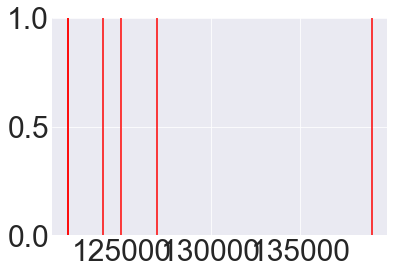

In [62]:
for abs_distance in distance_grid:
    print patient
    print abs_distance
    
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 220*samplerate
    period = 1
        
    ######### Epileptor Parameters ##########
    # intialized hard coded parameters
    epileptor_r = 0.0002/1.5    # Temporal scaling in the third state variable
    epiks = -0.01                 # Permittivity coupling, fast to slow time scale
    epitt = 0.025               # time scale of simulation
    epitau = 10                # Temporal scaling coefficient in fifth st var
    # x0c value = -2.05
    x0norm=-2.4
    x0ez=-1.7
    x0pz=-2.0

    # depends on epileptor variables of interest: it is where the x2-y2 var is
    varindex = [1]
    
    ######### Integrator Parameters ##########
    # parameters for heun-stochastic integrator
    heun_ts = 0.05
    noise_cov = np.array([0.001, 0.001, 0.,\
                    0.0001, 0.0001, 0.]) / 2.25
  
    root_dir = os.path.join('/Users/adam2392/Documents/pydata/')
    project_dir = os.path.join(root_dir, "metadata/",patient)
    print "Project directory for meta data is : ", project_dir
    tvbsim.util.renamefiles(patient, project_dir)
    
    ####### Initialize files needed to run tvb simulation
    sensorsfile = os.path.join(project_dir, "seeg.txt")
    gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    confile = os.path.join(project_dir, "connectivity.zip")
    
    use_subcort = 1
    verts, normals, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)

    ####################### 1. Structural Connectivity ########################
    con = tvbsim.initializers.connectivity.initconn(confile)
    
    # extract the seeg_xyz coords and the region centers
    seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
    seeg_labels = seeg_xyz.index.values
    region_centers = con.centres
    regions = con.region_labels
    num_regions = len(regions)
    
    # initialize object to assist in moving seeg contacts
    movecontact = tvbsim.util.MoveContacts(seeg_labels, seeg_xyz, 
                                       regions, region_centers, True)
    
    eznum = 1
    pznum = 1
    randez = np.random.randint(0, len(regions), size=eznum)
    randpz = np.random.randint(0, len(regions), size=pznum)

    if eznum <= 1:
        ezregion = list(regions[randez])
    else:
        ezregion = regions[randez]
    if pznum >= 1:
        pzregion = list(regions[randpz])
    elif pznum == 0:
        pzregion = []
    else:
        print >> sys.stderr, "Not implemented pz num >= 1 yet"
        raise
    
    if MOVECONTACT:
        ezindices = movecontact.getindexofregion(ezregion)
        pzindices = movecontact.getindexofregion(pzregion)
        
        ########## MOVE INDICES
        # move electrodes onto ez indices
        elecmovedindices = []
        for ezindex in ezindices:
            print "Moving onto current ez index: ", ezindex, " at ", regions[ezindex]
             # find the closest contact index and distance
            seeg_index, distance = movecontact.findclosestcontact(ezindex, elecmovedindices)

            # get the modified seeg xyz and gain matrix
            if distance != 0:
                modseeg, electrodeindices = movecontact.movecontactto(ezindex, seeg_index,distance)
            else:
                print "\n\nmoved contact onto ez exactly!!!!\n\n"
                modseeg, electrodeindices = movecontact.movecontact(ezindex, seeg_index)
            elecmovedindices.append(electrodeindices)
        
        # use subcortical structures!
        use_subcort = 1
        verts, normals, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
        modgain = tvbsim.util.gain_matrix_inv_square(verts, areas,
                            regmap, len(regions), movecontact.seeg_xyz)
        print "modified gain matrix the TVB way!"
    elif MOVECONTACT == 0:
        ########## SET EZREGION BASED ON CLOSENESS
        # find the closest region-contact pair
        for idx, label in enumerate(seeg_labels):
            region_index, distance = movecontact.getregionsforcontacts(label)

            if idx == 0:
                mindist = distance
                minregion = region_index
                mincontact = label
            else:
                if distance < mindist:
                    mindist = distance
                    minregion = region_index
                    mincontact = label
                    
        ezregion = minregion

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/varydistance/', 
                             'nez'+str(len(ezregion))+'_npz'+str(len(pzregion)) + 
                             '_dist' + str(int(abs_distance)) )
#                              patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    ezindices = movecontact.getindexofregion(ezregion)
    pzindices = movecontact.getindexofregion(pzregion)
    
    if not isinstance(ezindices, list):
        ezindices = np.array([ezindices])
    if not isinstance(pzindices, list):
        pzindices = np.array([pzindices])

    filename = os.path.join(outputdir, patient+'_sim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')
    print "Project directory for meta data is : ", project_dir
    print "File to be saved is: ", filename
    
    ####################### 2. Neural Mass Model @ Nodes ######################
    epileptors = tvbsim.initializers.models.initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                              x0ez, x0pz, ezindices, pzindices, num_regions)    
    ####################### 3. Integrator for Models ##########################
    heunint = tvbsim.initializers.integrators.initintegrator(heun_ts, noise_cov, noiseon=True)
    
    ################## 4. Difference Coupling Between Nodes ###################
    coupl = tvbsim.initializers.coupling.initcoupling(a=1.)
    ############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
    monitors = tvbsim.initializers.monitors.initmonitors(period, sensorsfile, gainmatfile, varindex)
    
    if MOVECONTACT:
        # modify the config of the monitors
        monitors[1].sensors.locations = movecontact.seeg_xyz
        monitors[1].sensors.locations = modseeg
        monitors[1].gain = modgain
        
    # get initial conditions and then setup entire simulation configuration
    initcond = initconditions(x0norm, num_regions)
    sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)
    times, epilepts, seegts = runsim(sim, sim_length)

    postprocessor = tvbsim.util.PostProcess(epilepts, seegts, times)
    ######################## POST PROCESSING #################################
    # post process by cutting off first 5 seconds of simulation
    # for now, don't, since intiial conditions
    times, epits, seegts, zts = postprocessor.postprocts(samplerate)
    
    print ezindices
    print pzindices
    # get the onsettimes and offsettimes for ez/pz indices
    onsettimes, offsettimes = getonsetsoffsets(zts, np.array(ezindices), np.array(pzindices))

    print "\nseizure onsets:", onsettimes
    print "seizure offsets:", offsettimes
    minsize = np.min((len(onsettimes),len(offsettimes)))

    # get the actual seizure times and offsets
    seizonsets, seizoffsets = getseiztimes(onsettimes, offsettimes)

    cutoff = None
    if len(onsettimes) > len(offsettimes):
        nextindex = np.where(onsettimes > seizoffsets[-1])[0][0]
        # create a cutoff for the entire simulated data
        cutoff = np.mean([onsettimes[nextindex], seizoffsets[-1]])

        print onsettimes[minsize], seizoffsets[-1]

        # floor to the nearest sample rate
        cutoff = int(math.floor(cutoff / float(samplerate)) * float(samplerate))

        plt.axvline(cutoff, color='red')
        epits = epits[:,0:cutoff]
        seegts = seegts[:, 0:cutoff]
        zts = zts[:, 0:cutoff]
        times = times[0:cutoff]
    
    print seizonsets, seizoffsets
    print onsettimes, offsettimes
    
    lowcut = 0.1
    highcut = 499.
    fs = 1000.
    x = seegts
    y = butter_highpass_filter(x, lowcut, fs, order=4)
    
    ######################## SAVING ALL DATA #################################
    regions = configs.connectivity.region_labels

    # Save files
    meta = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': regions,
        'regions_centers': configs.connectivity.centres,
        'seeg_contacts': configs.monitors[1].sensors.labels,
        'seeg_xyz': configs.monitors[1].sensors.locations,
        'ez': regions[ezindices],
        'pz': regions[pzindices],
        'ezindices': ezindices,
        'pzindices': pzindices,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'distance':distance,
        'patient':patient
    }

    # save tseries
    np.savez_compressed(filename, epits=epits, seegts=y, \
             times=times, zts=zts, metadata=meta)

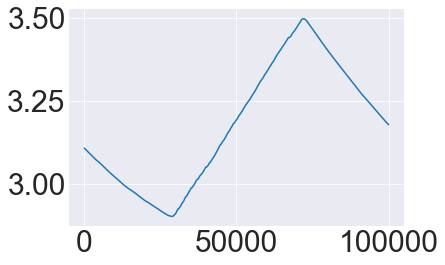

In [23]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(zts[ezindex,:].squeeze())

[]
[[16]]
ezreion is:  [['ctx-lh-parsopercularis']]
pzregion is:  [['Right-Pallidum']]
x0 values are (ez, pz, norm):  -1.7 -2.0 -2.4
time series shape is:  (84, 100000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
here: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]


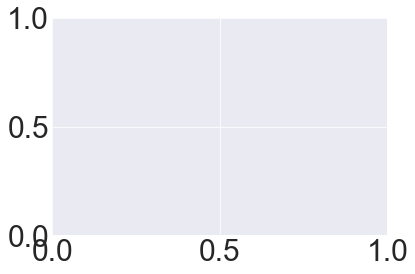

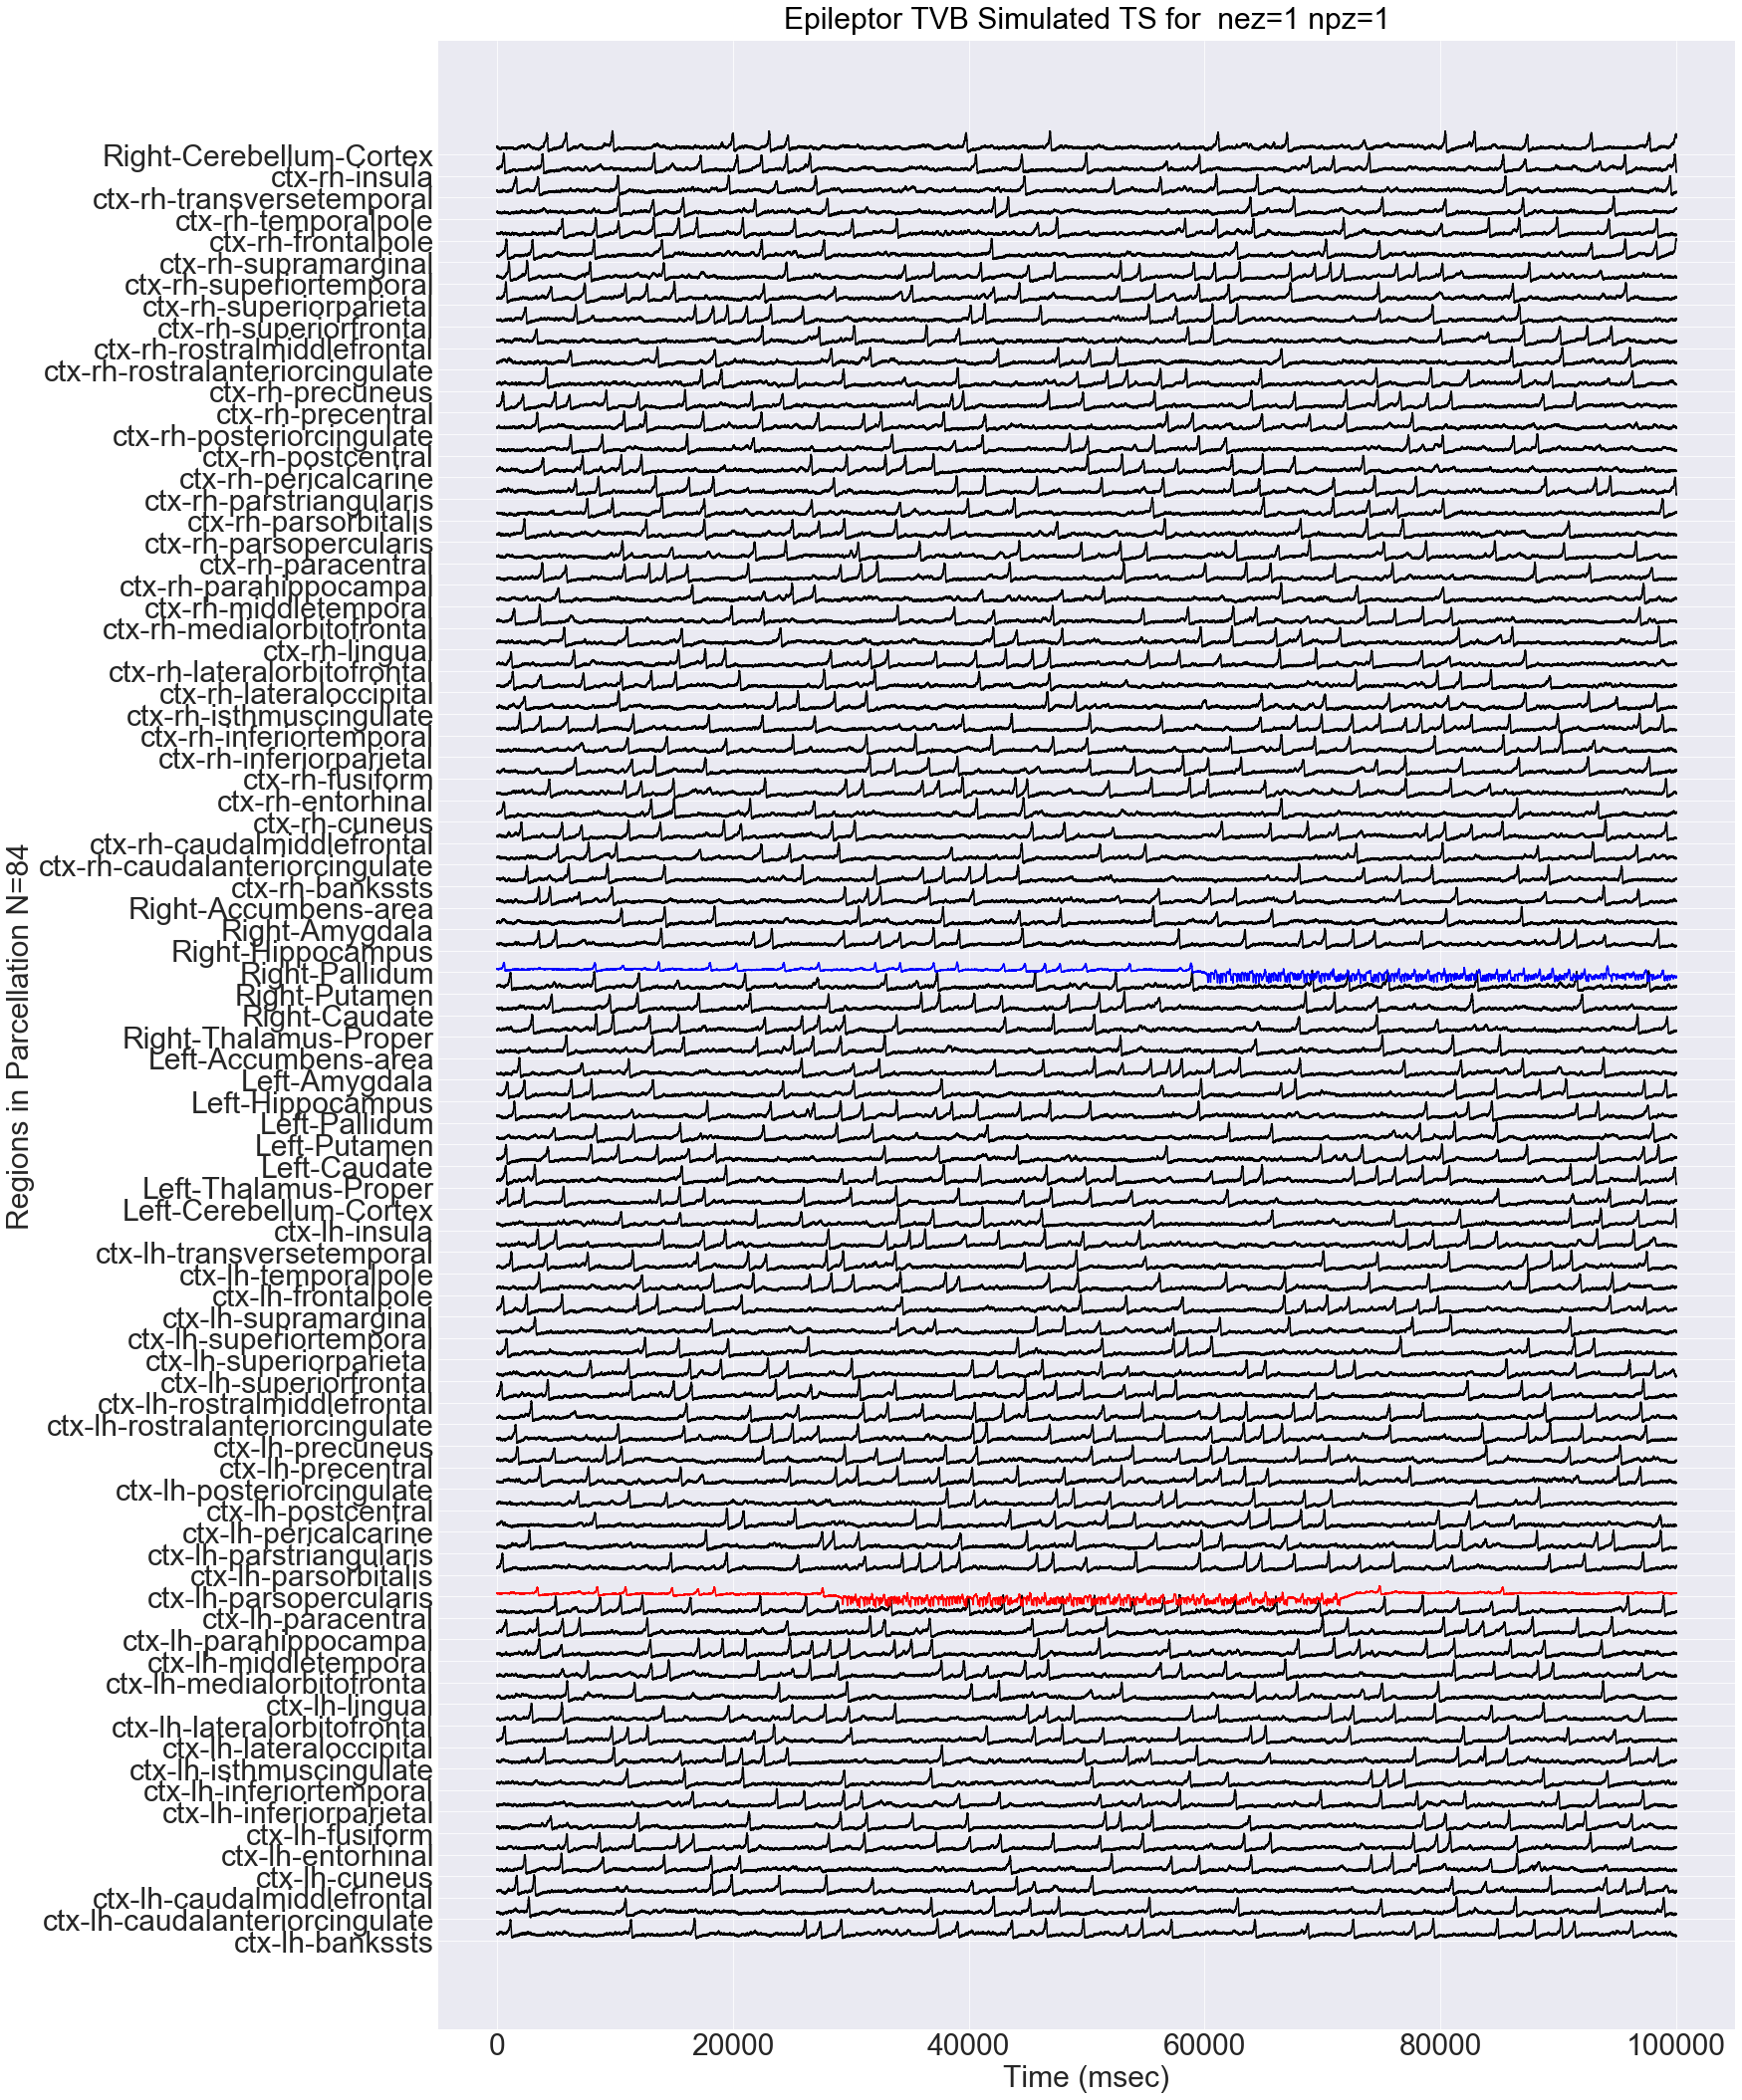

In [24]:
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
#     'onsettimes':seizonsets,
#     'offsettimes':seizoffsets,
    'distance':distance
}
rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)
onsettimes = []
offsettimes = []
print onsettimes
print meta['ezindices']
rawplotter.initializefig(figsize=(25,30))
epifig = rawplotter.plotepileptorts(epits, times, meta, onsettimes, offsettimes, plotsubset=False)

In [39]:
print len(onsettimes) 
print len(offsettimes)

def getseiztimes(onsettimes, offsettimes):
    minsize = np.min((len(onsettimes),len(offsettimes)))
    seizonsets = []
    seizoffsets = []
    
    # perform some checks
    if minsize == 0:
        print "no full onset/offset available!"
        return 0
    
    idx = 0
    # to store the ones we are checking rn
    _onset = onsettimes[idx]
    _offset = offsettimes[idx]
    seizonsets.append(_onset)
    
    # start loop after the first onset/offset pair
    for i in range(1,minsize):        
        # to store the previoius values
        _nextonset = onsettimes[i]
        _nextoffset = offsettimes[i]
        
        # check this range and add the offset if it was a full seizure
        # before the next seizure
        if _nextonset < _offset:
            _offset = _nextoffset
            
            if i == minsize-1 and len(seizoffsets) == 0:
                seizoffsets.append(_offset)
        else:
            seizoffsets.append(_offset)
            idx = i
            # to store the ones we are checking rn
            _onset = onsettimes[idx]
            _offset = offsettimes[idx]
            seizonsets.append(_onset)
    if len(seizonsets) != len(seizoffsets):
        seizonsets = seizonsets[0:len(seizoffsets)]
    return seizonsets, seizoffsets
            
# get the actual seizure times and offsets
seizonsets, seizoffsets = getseiztimes(onsettimes, offsettimes)

print onsettimes
print offsettimes
print seizonsets
print seizoffsets

4
2
[  32433.   64177.  179979.  207493.]
[ 95268.  99848.]
[32433.0]
[99848.0]
